# In this notebook I match catalogs from SDSS DR7 by Meert et al. and Yang et al.

### Preliminary imports

In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import interp1d
from statsmodels.stats.weightstats import DescrStatsW

def fits_to_pandas(filename, extension):
    tb = fits.open(filename)
    return Table(tb[extension].data).to_pandas()


### Cosmology and units

In [2]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import matplotlib.pylab as plt
from astropy.coordinates import Angle
from astropy import units as u

%matplotlib inline
m_nu=Quantity([ 0.,    0. ,   0.06] , 'eV')
cosmo_model=FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725, Neff=3.05, m_nu=m_nu, Ob0=0.0486)
appmax = 17.7   #maximum apparent mag
appmin = 14.5   #minimum apparent mag
qevol = 1.3    #evolution factor for colors (?)


def get_half_light_radius(Lumdistances,z, re_arcsec):    #returns half light radius in kpc
    

    AngDistances = LumDistances/(1+z)**2 # [Mpc]
    re_arcsec = Angle(re_arcsec, u.arcsec)
    re_rad = re_arcsec.radian
    re_Mpc = AngDistances*re_rad
    
    return np.log10(re_Mpc)+3 

### READ DATABASES 

In [3]:

df_MsMendel = pd.read_csv('UPenn_PhotDec_Mstar_mlMendel14.dat', 
                          names=['galcount','msflagserexp','MsMendSerExp','MsMendCmodel'],
                          usecols=(0,1,4,9), delim_whitespace = True) #use truncated Mstar, with dust

df_modelC1 = pd.read_csv('imodelC_1', 
                         names=['YgalID','galgroupId','LCentSat','MCentSat'], 
                         usecols=(0,2,3,4), skiprows=1, delim_whitespace=True)

df_modelCgroup =pd.read_csv('modelC_group',
                            names=['groupId','MhaloL','MhaloM'],
                            usecols=(0,6,7),skiprows=1 ,delim_whitespace=True)

df_galtable = pd.read_csv('galtable_fiber2mag_all_dr7.txt', 
                          names=['galcount','ra','dec','z','petror','modelr','extictionr','kcorrr'],
                          usecols=(0,1,2,3,8,11,17,20), skiprows=1,delim_whitespace=True)


#this table matches the objects in Meert (galcount) and Yang (YgalId) catalogs
df_matched = pd.read_csv('matched_coordinates3arcsec.dat' , 
                         names=['YgalID','galcount','raSDSS7','decSDSS7','zSDSS7',
                                'raMeert','decMeert','zMeert','veldisp','veldisperr'],
                         skiprows=1, delim_whitespace=True) 

df_SDSS7 = pd.read_csv('SDSS7', 
                       names= ['YgalID','ra','dec','z','appmPet','Mpet','Mmod','zType'], 
                       skiprows=1, delim_whitespace=True, usecols=(0,2,3,4,5,8,10,12))

df_YangMeert = pd.read_csv('YANG_Meert15.dat',
                          names=['galcount','flagserexp'],
                          skiprows=1, delim_whitespace=True, usecols=(1,19))


In [4]:
#df_YangMeert = pd.read_csv('YANG_Meert15.dat', names=['YgalID', 'galcount', 'plate', 'mjd', 'fiberid', 'ra', ' dec', 'z',
#       ' S11appmagr', ' SDSS12cmodelr', 'M15appmagr', 'M15appmagrtrunc',
#       'M15appmagrSer', 'M15appmagrSertrunc', 'MsMendSerExp',
#       'MsMendSerExptrunc', 'MsMendSer', 'MsMendSertrunc', 'GalType',
#       'flagserexp', 'flagser'], skiprows=1, delim_whitespace=True)


In [5]:
#df_YangMeert = df_YangMeert.rename(columns={'z':'zMeert'}, copy=False)

In [6]:
#len(df_matched[np.logical_not(df_matched.duplicated(subset='galcount'))])

In [7]:
df_rband = fits_to_pandas('UPenn_PhotDec_Models_rband_Lorenzo.fits', extension=1) # "best fit"
#df_rband = fits_to_pandas('UPenn_PhotDec_Models_rband.fits', extension=1)
df_H2011 = fits_to_pandas('UPenn_PhotDec_H2011.fits', extension=1)

df_CAST = fits_to_pandas('UPenn_PhotDec_CAST.fits', extension=1)

In [8]:
df_rband.columns

Index(['M_TOT', 'M_APER', 'BT', 'R_TOT', 'BA_TOT', 'BT_APER', 'XCTR_BULGE',
       'XCTR_BULGE_ERR', 'YCTR_BULGE', 'YCTR_BULGE_ERR', 'M_BULGE',
       'M_BULGE_ERR', 'R_BULGE', 'R_BULGE_ERR', 'N_BULGE', 'N_BULGE_ERR',
       'BA_BULGE', 'BA_BULGE_ERR', 'PA_BULGE', 'PA_BULGE_ERR', 'XCTR_DISK',
       'XCTR_DISK_ERR', 'YCTR_DISK', 'YCTR_DISK_ERR', 'M_DISK', 'M_DISK_ERR',
       'R_DISK', 'R_DISK_ERR', 'N_DISK', 'N_DISK_ERR', 'BA_DISK',
       'BA_DISK_ERR', 'PA_DISK', 'PA_DISK_ERR', 'GALSKY', 'GALSKY_ERR',
       'CHI2NU', 'FINALFLAG', 'AUTOFLAG', 'PYFLAG', 'PYFITFLAG', 'galcount'],
      dtype='object')

In [9]:
#df_rband['galcount'] = df_rband.index+1
df_rband = df_rband[['galcount', 'M_TOT','BT','R_TOT','N_BULGE','FINALFLAG','BA_TOT','N_DISK']]
#df_rband=df_rband[['galcount','m_tot','BT','r_tot','n_bulge','finalflag','ba_tot','n_disk']]

df_rband.columns=['galcount','m_tot','BT','r_tot_circ','n_bulge','finalflag','ba_tot','n_disk']


In [10]:
df_DS2018  = fits_to_pandas('DL_morphology_SDSS_DS18.fit', extension=1)


In [11]:
df_DS2018.columns

Index(['dr7objid', 'galcount', 'P_disk', 'P_edge_on', 'P_bar_GZ2',
       'P_bar_Nair10', 'P_merg', 'P_bulge', 'P_cigar', 'TType', 'P_S0'],
      dtype='object')

In [12]:
df_DS2018 = df_DS2018[['galcount','TType','P_S0','P_bar_GZ2','P_bar_Nair10']]

#df_rband = df_rband[['galcount','m_tot','BT','r_tot',
#                     'n_bulge','finalflag','ba_tot','n_disk']]#,'m_disk','r_disk']]
#df_rband = df_rband.rename(columns={'r_tot':'r_tot_circ'})
df_CAST = df_CAST[['galcount','objid']]

In [13]:
df_SDSS7['corrections'] = df_SDSS7.appmPet - df_SDSS7.Mpet 

In [14]:
R80bulges = pd.read_csv('Rtrunc80_bulges.txt', names=['galcount','R80'], usecols=(0,1),delim_whitespace=True)
R80disks = pd.read_csv('Rtrunc80_disks.txt', names=['galcount','R80'], usecols=(0,1),delim_whitespace=True)
R80_two_comp = pd.read_csv('Rtrunc80_two_comp.txt', names=['galcount','R80'], usecols=(0,1),delim_whitespace=True)
R80trunc_prob_two_comp = pd.read_csv('Rtrunc80_prob_two_comp.txt', names=['galcount','R80'], usecols=(0,1), delim_whitespace=True )
df_r80 = pd.concat([R80bulges,R80disks, R80_two_comp,R80trunc_prob_two_comp])
df_r80.loc[:,'galcount'] = df_r80['galcount'].values.astype(int)

In [15]:
Rtrunc_two_comp = pd.read_csv('Rtrunc_two_comp.txt', names=['galcount','r_tot','r_trunc'], usecols=(0,1,2), delim_whitespace=True )
Rtrunc_prob_two_comp = pd.read_csv('Rtrunc_prob_two_comp.txt', names=['galcount','r_tot','r_trunc'], usecols=(0,1,2), delim_whitespace=True )
Rtrunc_disks = pd.read_csv('Rtrunc_disks.txt', names=['galcount','r_tot','r_trunc'], usecols=(0,1,2), delim_whitespace=True )
Rtrunc_bulges = pd.read_csv('Rtrunc_bulges.txt', names=['galcount','r_tot','r_trunc'], usecols=(0,1,2),delim_whitespace=True )
trunc = pd.concat([Rtrunc_bulges,Rtrunc_disks,Rtrunc_two_comp,Rtrunc_prob_two_comp])
trunc.loc[:,'galcount'] = trunc['galcount'].values.astype(int)

### faintness & goodness of fit cuts

In [16]:
len(trunc),len(df_r80)

(627433, 627433)

In [17]:
index_faintness = (df_galtable.petror < appmax) & (df_galtable.petror > appmin)
index_valid_magnitudes = df_rband.m_tot != -999
index_msflag = df_MsMendel.msflagserexp == 0
index_valid_radii = df_rband.r_tot_circ > 0
index_valid_ba = df_rband.ba_tot >0
index_valid_kcorr = df_galtable.kcorrr != -999.
index_valid_ext = df_galtable.extictionr != -999.
index_valid_mass = df_MsMendel.MsMendSerExp > 0
#index_valid_flag = df_H2011.probaE > 0
#index_valid_bulge = df_rband.r_bulge > 0
ind = index_faintness & index_valid_magnitudes & index_valid_radii  \
        &index_valid_kcorr &index_valid_ba & index_valid_ext &index_valid_mass & index_msflag #&index_valid_bulge
    

df_rband = df_rband[ind]
df_MsMendel = df_MsMendel[ind]
df_rband['r_tot_original'] = df_rband['r_tot_circ']/np.sqrt(df_rband['ba_tot'])

In [18]:
np.count_nonzero(index_faintness.astype(int))   #faintness cut is huge!

558239

### ASSIGN GALAXIES TO YANG ET AL GROUPS

In [19]:
df_merged = df_modelC1.merge(df_modelCgroup, left_on='galgroupId',right_on='groupId')
df_merged.drop('galgroupId', axis=1,inplace=True)
len(df_merged)

639359

In [20]:
df_merged.columns, df_SDSS7.columns

(Index(['YgalID', 'LCentSat', 'MCentSat', 'groupId', 'MhaloL', 'MhaloM'], dtype='object'),
 Index(['YgalID', 'ra', 'dec', 'z', 'appmPet', 'Mpet', 'Mmod', 'zType',
        'corrections'],
       dtype='object'))

In [21]:
df_merged=df_merged.merge(df_SDSS7, on='YgalID')



In [22]:
df_merged.columns

Index(['YgalID', 'LCentSat', 'MCentSat', 'groupId', 'MhaloL', 'MhaloM', 'ra',
       'dec', 'z', 'appmPet', 'Mpet', 'Mmod', 'zType', 'corrections'],
      dtype='object')

In [23]:
len(df_merged)

639359

### MATCH YANG ET AL. IDs AND MEERT ET AL. GALCOUNTs THROUGH THE MATCHED TABLE

In [24]:
#df_merged = df_merged.merge(df_YangMeert, on='YgalID')
df_merged = df_merged.merge(df_matched, on='YgalID')
len(df_merged)

584382

In [25]:
df_merged.columns

Index(['YgalID', 'LCentSat', 'MCentSat', 'groupId', 'MhaloL', 'MhaloM', 'ra',
       'dec', 'z', 'appmPet', 'Mpet', 'Mmod', 'zType', 'corrections',
       'galcount', 'raSDSS7', 'decSDSS7', 'zSDSS7', 'raMeert', 'decMeert',
       'zMeert', 'veldisp', 'veldisperr'],
      dtype='object')

### MATCH ALL THE REMAINING CATALOGS 

In [26]:
df_merged = df_merged.merge(df_rband, on='galcount')
len(df_merged)


486182

In [27]:
df_merged = df_merged.merge(df_MsMendel, on='galcount')
len(df_merged)

486182

In [28]:
df_merged = df_merged.merge(df_DS2018, on='galcount')
len(df_merged)

486182

In [29]:
df_merged = df_merged.merge(df_galtable, on='galcount')


In [30]:
df_merged = df_merged.merge(df_CAST, on='galcount')

In [31]:
len(df_merged)

486182

In [32]:

df_merged = df_merged.merge(df_r80, on='galcount')
df_merged = df_merged.merge(trunc, on='galcount')

#a= df_merged['r_trunc']*np.sqrt(df_merged['ba_tot'].values)
#df_merged['r_trunc']=a


In [33]:
df_r80

,galcount,R80
0,24,13.077400
1,27,9.360360
2,32,11.160000
3,42,8.528200
4,51,10.480900
5,52,7.602590
6,56,12.649100
7,62,13.744800
8,65,19.556700
9,71,47.035100


In [34]:
len(df_merged)

484382

In [35]:
saved_df = df_merged.copy()

## get Re for the whole galaxy

In [36]:
LumDistances = cosmo_model.luminosity_distance(df_merged['zMeert'].values).value  # [Mpc]
df_merged['LumDistance']=  LumDistances

df_merged['logReSerExpNotTrunc'] = get_half_light_radius(df_merged.LumDistance.values,df_merged.zMeert.values,df_merged.r_tot_original.values)
df_merged['logReSerExp'] = get_half_light_radius(df_merged.LumDistance.values,df_merged.zMeert.values,df_merged.r_trunc.values)
df_merged['logReSerExpCircNotTrunc'] = get_half_light_radius(df_merged.LumDistance.values,df_merged.zMeert.values,df_merged.r_tot_circ.values)
df_merged['logR80NotTrunc'] = get_half_light_radius(df_merged.LumDistance.values,df_merged.zMeert.values,df_merged.R80.values)

#df_merged['logRedisk'] = get_half_light_radius(df_merged.LumDistance.values, df_merged.zMeert.values,
                                              #df_merged.r_disk.values)

#df_merged['logRebulge'] = get_half_light_radius(df_merged.LumDistance.values, df_merged.zMeert.values,
                                             #df_merged.r_bulge.values)



/home/lorenzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


In [37]:
df_merged.columns

Index(['YgalID', 'LCentSat', 'MCentSat', 'groupId', 'MhaloL', 'MhaloM', 'ra_x',
       'dec_x', 'z_x', 'appmPet', 'Mpet', 'Mmod', 'zType', 'corrections',
       'galcount', 'raSDSS7', 'decSDSS7', 'zSDSS7', 'raMeert', 'decMeert',
       'zMeert', 'veldisp', 'veldisperr', 'm_tot', 'BT', 'r_tot_circ',
       'n_bulge', 'finalflag', 'ba_tot', 'n_disk', 'r_tot_original',
       'msflagserexp', 'MsMendSerExp', 'MsMendCmodel', 'TType', 'P_S0',
       'P_bar_GZ2', 'P_bar_Nair10', 'ra_y', 'dec_y', 'z_y', 'petror', 'modelr',
       'extictionr', 'kcorrr', 'objid', 'R80', 'r_tot', 'r_trunc',
       'LumDistance', 'logReSerExpNotTrunc', 'logReSerExp',
       'logReSerExpCircNotTrunc', 'logR80NotTrunc'],
      dtype='object')

### ....and throw away nan and inf

In [38]:
df_merged.logReSerExp.fillna(-999., inplace=True)
df_merged.logReSerExpCircNotTrunc.fillna(-999., inplace=True)
df_merged.logReSerExpNotTrunc.fillna(-999., inplace=True)
df_merged.logR80NotTrunc.fillna(-999., inplace=True)

df_merged.replace(to_replace=-np.inf, value = -999., inplace=True)

### format LCentstat and MCentsat

In [39]:
df_merged['LCentSat'].replace(to_replace=2, value=0, inplace=True)
df_merged['MCentSat'].replace(to_replace=2, value=0, inplace=True)


In [40]:
df_merged['mred_corrected'] = df_merged.m_tot -df_merged.kcorrr- \
               df_merged.extictionr + qevol*df_merged.zMeert

df_merged['AbsMag'] = df_merged.mred_corrected -5*np.log10(df_merged.LumDistance) -25
#df_merged['AbsMag'] =df_merged.modelr -df_merged.kcorrr + qevol*df_merged.z -5*np.log10(df_merged.LumDistance) -25

In [41]:
#df_merged['AbsModel_YangCorrected'] = df_merged.modelr-df_merged.corrections

In [42]:
#df_merged['AbsModel_YangCorrected'].hist(normed=True,bins=np.arange(-24,-14,1))
#df_SDSS7[(df_SDSS7.appmPet>appmin) & (df_SDSS7.appmPet<appmax)].Mmod.hist(normed=True,bins=np.arange(-24,-14,1),alpha=0.3)

In [43]:
df_merged.columns

Index(['YgalID', 'LCentSat', 'MCentSat', 'groupId', 'MhaloL', 'MhaloM', 'ra_x',
       'dec_x', 'z_x', 'appmPet', 'Mpet', 'Mmod', 'zType', 'corrections',
       'galcount', 'raSDSS7', 'decSDSS7', 'zSDSS7', 'raMeert', 'decMeert',
       'zMeert', 'veldisp', 'veldisperr', 'm_tot', 'BT', 'r_tot_circ',
       'n_bulge', 'finalflag', 'ba_tot', 'n_disk', 'r_tot_original',
       'msflagserexp', 'MsMendSerExp', 'MsMendCmodel', 'TType', 'P_S0',
       'P_bar_GZ2', 'P_bar_Nair10', 'ra_y', 'dec_y', 'z_y', 'petror', 'modelr',
       'extictionr', 'kcorrr', 'objid', 'R80', 'r_tot', 'r_trunc',
       'LumDistance', 'logReSerExpNotTrunc', 'logReSerExp',
       'logReSerExpCircNotTrunc', 'logR80NotTrunc', 'mred_corrected',
       'AbsMag'],
      dtype='object')

In [44]:
#df_merged = df_merged.drop(columns=['ra_x','dec_x', 'z_x', 'appmPet', 'Mpet', 'Mmod', 'zType', 'corrections',
#               'raSDSS7', 'decSDSS7', 'zSDSS7','m_tot','m_tot','ra_y', 'dec_y', 'z_y',
#               'petror', 'modelr','mred_corrected','R80','LumDistance','r_tot_circ'])

In [45]:
df_merged_M = df_merged.copy()
df_merged_L = df_merged.copy()

### CENTRAL GALAXIES ARE THE MOST MASSIVE.....

#### reorder cen sat labels according to new photometry (Mass)

In [46]:
## Centrals in Yang
groupsWithCentralsYang = df_merged_M[df_merged_M.MCentSat==1].groupId
groupsWithCentralsYang = pd.DataFrame({'groupId': groupsWithCentralsYang})
df_YangCen = groupsWithCentralsYang.merge(df_merged_M, on='groupId', copy=False)

In [47]:
df_merged_M.columns

Index(['YgalID', 'LCentSat', 'MCentSat', 'groupId', 'MhaloL', 'MhaloM', 'ra_x',
       'dec_x', 'z_x', 'appmPet', 'Mpet', 'Mmod', 'zType', 'corrections',
       'galcount', 'raSDSS7', 'decSDSS7', 'zSDSS7', 'raMeert', 'decMeert',
       'zMeert', 'veldisp', 'veldisperr', 'm_tot', 'BT', 'r_tot_circ',
       'n_bulge', 'finalflag', 'ba_tot', 'n_disk', 'r_tot_original',
       'msflagserexp', 'MsMendSerExp', 'MsMendCmodel', 'TType', 'P_S0',
       'P_bar_GZ2', 'P_bar_Nair10', 'ra_y', 'dec_y', 'z_y', 'petror', 'modelr',
       'extictionr', 'kcorrr', 'objid', 'R80', 'r_tot', 'r_trunc',
       'LumDistance', 'logReSerExpNotTrunc', 'logReSerExp',
       'logReSerExpCircNotTrunc', 'logR80NotTrunc', 'mred_corrected',
       'AbsMag'],
      dtype='object')

In [48]:
df_select_centralsM =  df_YangCen.groupby(by='groupId', as_index=False)[['MsMendSerExp']].max()
df_merged_M = df_merged_M.merge(df_select_centralsM, on='groupId')


In [49]:
df_merged_M.rename(columns={'MsMendSerExp_x':'MsMendSerExp','MsMendSerExp_y': 'MsCent'}, inplace=True)


In [50]:
select_centM = df_merged_M.MsMendSerExp == df_merged_M.MsCent                                                                              
select_centM = select_centM.values.astype(int)
df_merged_M['NewMCentSat'] = select_centM  #  1=Central, 0=Satellite


In [51]:
## groups with non matched centrals: only satellites are contained here
ComputeMax= df_merged[['MCentSat','groupId']].groupby('groupId', as_index=False).max()
groups_nonYang = ComputeMax[ComputeMax.MCentSat == 0]
df_nonYang  = df_merged.merge(groups_nonYang, on='groupId')

In [52]:
df_nonYang['NewMCentSat'] = 0  #they are ALL satellites!

In [53]:
df_nonYang.drop(['MCentSat_x','MCentSat_y'], axis=1, inplace=True)

In [54]:
df_merged_M = df_merged_M.append(df_nonYang)

/home/lorenzo/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [55]:
len(df_merged_M)

484382

### ...OR THE MOST LUMINOUS

#### reorder cen sat labels according to new photometry (AbsMag)

In [56]:
## Centrals in Yang
groupsWithCentralsYang = df_merged_L[df_merged_L.LCentSat==1].groupId
groupsWithCentralsYang = pd.DataFrame({'groupId': groupsWithCentralsYang})
df_YangCen = groupsWithCentralsYang.merge(df_merged_L, on='groupId')

In [57]:
df_select_centralsL =  df_YangCen.groupby(by='groupId', as_index=False)[['AbsMag']].min()
df_merged_L = df_merged_L.merge(df_select_centralsL, on='groupId')

In [58]:
df_merged_L.rename(columns={'AbsMag_x':'AbsMag','AbsMag_y':'AbsMagCent'}, inplace=True)

In [59]:
select_centL = df_merged_L.AbsMag == df_merged_L.AbsMagCent
select_centL = select_centL.values.astype(int)
df_merged_L['NewLCentSat'] = pd.Series(select_centL)   #  1=Central, 0=Satellite

In [60]:
## groups with non matched centrals: only satellites are contained here
ComputeMax= df_merged[['LCentSat','groupId']].groupby('groupId', as_index=False).max()
groups_nonYang = ComputeMax[ComputeMax.LCentSat == 0]
df_nonYang  = df_merged.merge(groups_nonYang, on='groupId')

In [61]:
df_nonYang.drop(['LCentSat_x','LCentSat_y'], axis=1, inplace=True)

In [62]:
df_nonYang['NewLCentSat'] = 0  #they are ALL satellites!

In [63]:
df_merged_L = df_merged_L.append(df_nonYang)

/home/lorenzo/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [64]:
len(df_merged_L)

484382

### join the tables

In [65]:
df_merged_new = df_merged_L.merge(df_merged_M, on='galcount',suffixes=('','_y'))

In [66]:
df_merged_new.galcount.describe()

count    484382.000000
mean     337115.303269
std      194026.222047
min           1.000000
25%      170522.500000
50%      338979.500000
75%      506213.750000
max      670718.000000
Name: galcount, dtype: float64

In [67]:
#df_merged_new.drop([ 'z_x','BT_y',
#       'LCentSat_y', 'LumDistance_y', 'MCentSat_y', 'MhaloL_y', 'MhaloM_y',
#        'MsMendSerExp_y',   'YgalID_y',
#       'decMeert_y', 'extictionr_y', 'groupId_y', 'kcorrr_y', 'logReSerExp_y',
#       'm_tot_y', 'n_bulge_y', 'petror_y', 'probaE_y', 'probaEll_y',
#       'probaS0_y', 'probaSab_y', 'probaScd_y', 'r_tot_y', 'raMeert_y',
#       'zMeert_y', 'z_x_y'], axis=1, inplace=True)

In [68]:
df_merged_new.drop(['m_tot','r_tot','mred_corrected','extictionr','kcorrr',
                  'LumDistance'], axis=1, inplace=True)

In [69]:
df_merged_new.fillna(-999., inplace=True)

In [70]:
df_merged_new.galcount.describe()


count    484382.000000
mean     337115.303269
std      194026.222047
min           1.000000
25%      170522.500000
50%      338979.500000
75%      506213.750000
max      670718.000000
Name: galcount, dtype: float64

In [71]:
#df_merged_new = df_merged.copy()

### checking how many objects in a given group - prsently commented

import matplotlib.pylab as plt
df = df_merged.groupby(by='groupId', as_index=False).count().YgalID.values
df_new = df[df>10]
print(len(df_new)/len(df))
plt.hist(df_new, 
         bins=np.linspace(1, 600, 100))
plt.show()
df_merged.groupby(by='groupId', as_index=False).count()

###  Yang et al. sample is SDSS+2df+KSG-VAC+others.  We want to keep only SDSS objects

select_SDSS_only =  (df_SDSS7.zType==-1) | (df_SDSS7.zType==1) | (df_SDSS7.zType==5)
df_SDSSonly = df_SDSS7[select_SDSS_only]
df_mergedSDSSonly = df_merged.merge(df_SDSSonly, on='YgalID')


len(df_mergedSDSSonly)

df_merged_all = df_merged.merge(df_SDSS7, on='YgalID')



d1 = df_merged.sort_values(by='groupId')
d1n = d1.groupby(by='groupId').count().YgalID.values
#d1n =d1n[d1n>10]
bins=np.linspace(10,600,100)
plt.hist(d1n, bins=bins, label='All', color='darkblue', alpha=0.6)

d2 = df_mergedSDSSonly.sort_values(by='groupId')
d2n = d2.groupby(by='groupId').count().YgalID.values
#d2n =d2n[d2n>10]
plt.hist(d2n, bins=bins, label='SDSSonly', alpha=0.8, color='red'
        )
print(len(d1), len(d2))

plt.legend()
plt.yscale('log')
plt.xscale('log')

# Now add Vmax weights

In [72]:
appmax = 17.7   #maximum apparent mag
appmin = 14.5   #minimum apparent mag
qevol = 1.3    #evolution factor for colors (?)

In [73]:
df_vmax = df_merged_new.copy()

In [74]:
zmin  = min(df_vmax.zMeert.values)
zmax = max(df_vmax.zMeert.values)


In [75]:
df_kcorr = pd.read_csv('2dfsdss_kcorr.dat', skiprows=3, 
                       names=['zk','age','cug','cgr','cri','ciz','cu','cg','cr','ci','ctz','ku','kg','kr','ki','kz'],
                      delim_whitespace=True)

In [76]:
dztable = 0.00005
ztable = np.arange(0,19000*dztable,dztable)
Ezint = np.sqrt(cosmo_model.Om0*(1.+ztable - dztable/2.)**3 + 1.-cosmo_model.Om0)
coverh=(2997./cosmo_model.h)     
dComtable = coverh*dztable*np.cumsum(1/Ezint)


In [77]:
max(ztable),df_kcorr.zk.max()

(0.9499500000000001, 0.99)

In [78]:
Vztable = 4*np.pi/3*dComtable**3
dLum = (1+ztable)*dComtable

In [79]:
krinterpol = interp1d(df_kcorr.zk.values,df_kcorr.kr.values)
kztable = krinterpol(ztable)

In [80]:

appmaxz = appmax-kztable + qevol*ztable
appminz = appmaxz + appmin -appmax


In [81]:
absBright = abs(appminz - 25 -5*np.log10(dLum))
absFaint = absBright + appmin - appmax

In [82]:
max(absFaint), min(absFaint)

(26.816970302823425, 3.9528179650657336)

In [83]:
df_vmax = df_vmax[abs(df_vmax.AbsMag)<np.max(absFaint)]

In [84]:
absMtable = abs(df_vmax.AbsMag.values)

In [85]:


VminInterp = interp1d(absBright, Vztable, kind='quadratic')   
Vmin = VminInterp(absMtable)

VmaxInterp = interp1d(absFaint, Vztable, kind='quadratic')
Vmax = VmaxInterp(absMtable)




In [86]:
tmin = np.where(ztable <= zmin)[0]
Vztableok = Vztable[tmin]
Vzmin = Vztableok[len(Vztableok)-1]
Vzmin

326545.0545903738

In [87]:
tmax = np.where(ztable >= zmax)[0]
Vztableok =Vztable[tmax]
Vzmax = Vztableok[0]
Vzmax


2289807593.622664

In [88]:
tvmin = np.where(Vmin <= Vzmin)
if ( len(tvmin) != 0 ):
    Vmin[tvmin] = Vzmin
tvmax = np.where(Vmax >= Vzmax)
if (len(tvmax) !=0 ):
    Vmax[tvmax] = Vzmax


In [89]:
Vcominterp = interp1d(ztable, Vztable)
Vcomzdata = Vcominterp(df_vmax.zMeert.values)  ## comoving volume for each source

In [90]:
appmaxzinterp = interp1d(ztable, appmaxz)
appmaxzdata = appmaxzinterp(df_vmax.zMeert.values)


In [91]:
appminzinterp = interp1d(ztable, appminz)
appminzdata = appminzinterp(df_vmax.zMeert.values)


In [92]:
Vmaxwt = np.zeros(len(df_vmax))

In [93]:
okmax = Vmax > Vzmin
okmin = Vmin < Vzmax
ok = okmax & okmin
Vmaxwt[ok] = 1./(Vmax[ok]-Vmin[ok])
Vmaxwt[np.logical_not(ok)] = -999.
Vmaxwt[Vmaxwt<0] = -999.
len(Vmaxwt), len(df_merged_new)

(484382, 484382)

In [94]:
df_vmax['Vmaxwt'] = Vmaxwt
df_vmax = df_vmax[['Vmaxwt','galcount']]
df_vmax.galcount.describe()

count    484382.000000
mean     337115.303269
std      194026.222047
min           1.000000
25%      170522.500000
50%      338979.500000
75%      506213.750000
max      670718.000000
Name: galcount, dtype: float64

In [95]:
df_merged_new = df_merged_new.merge(df_vmax, on='galcount')

In [96]:
len(df_merged_new.galcount.unique())

484382

In [97]:
df_merged_new.loc[df_merged_new.finalflag==5,'BT']=0
df_merged_new.loc[df_merged_new.finalflag==1,'BT']=1

In [110]:
df_merged_new.columns

Index(['AbsMag', 'AbsMagCent', 'BT', 'LCentSat', 'MCentSat', 'MhaloL',
       'MhaloM', 'Mmod', 'Mpet', 'MsMendCmodel',
       ...
       'ra_x_y', 'ra_y_y', 'veldisp_y', 'veldisperr_y', 'zMeert_y', 'zSDSS7_y',
       'zType_y', 'z_x_y', 'z_y_y', 'Vmaxwt'],
      dtype='object', length=110)

## FORMAT OUTPUT

### Setting MsCent as the mass of the central inferred from LUMINOSITY
### Setting halo mass as MhaloM
### Using luminosity only to define central

In [111]:
to_replace = df_merged_new[df_merged_new.NewLCentSat==1]['MsCent'] 
replaced = df_merged_new[df_merged_new.NewLCentSat==1]['MsMendSerExp']

df_merged_new.replace(to_replace=to_replace, value=replaced, inplace=True)

In [112]:
#df_merged_new = df_merged_new.rename({'AbsMag':'AbsModel'},axis=1)

In [524]:
df_merged_new_=  df_merged_new[['galcount','zMeert','Vmaxwt','NewLCentSat','MsMendSerExp',
                               'MsCent','AbsMag','logReSerExp', 'logReSerExpNotTrunc',
                               'logReSerExpCircNotTrunc','logR80NotTrunc','BT','n_bulge','ba_tot','TType','P_S0',
                               'P_bar_GZ2','P_bar_Nair10' ,'finalflag','n_disk']]


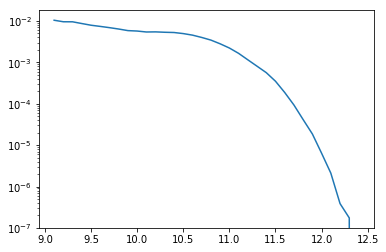

In [178]:
bins=np.arange(9,12.5,0.1)
df_merged_new = df_merged_new[df_merged_new.Vmaxwt>0]
fracper=len(df_merged_new)/670722
skycov=8000.
fracsky=(skycov*fracper)/(4*np.pi*(180./np.pi)**2.)

hist_corr = np.histogram(df_merged_new.MsMendSerExp.values, weights=df_merged_new.Vmaxwt.values, bins=bins)[0]
hist_corr = hist_corr/0.1/fracsky
plt.plot(bins[1:],hist_corr)

hist_mendel = np.histogram(df_MsMendel.MsMendSerExp.values, weight)
plt.yscale('log')


In [93]:
histo_Ms =hist_corr.copy()

In [80]:
df_nonan = df_merged_new.fillna(-999)

In [61]:
df_merged_new = df_merged_new.rename(columns={'AbsMag':'AbsModel'})

In [103]:
df_merged_new_.to_csv('Catalog_SDSS_complete.dat',sep=' ', index=False)


In [67]:
len(df_merged_new[df_merged_new.NewLCentSat!=-999])/670722

0.7239646231970921

In [70]:
len(df_merged_new[df_merged_new.probaScd== -888.])

679

In [166]:
    def calc_ReMstar(df, binstart, s, w=None):
        
       # if s=='etgs':
        #    Vmaxwt= df.Vmaxwt.values*( df.probaEll.values + df.probaS0.values)
        #elif s=='ltgs':
         #   Vmaxwt= df.Vmaxwt.values*( df.probaSab.values + df.probaScd.values)

        
        if w is not None:
            Weights=w.copy()
        Ms = abs(df.MsMendSerExp.values)
        Re = df.logReSerExp.values

        Vmaxwt= df.Vmaxwt.values
        Weights=Vmaxwt.copy()
        HM_Mask = np.ma.masked_inside(Ms, binstart, binstart+0.1).mask#HM_Bin+0.5).mask
        #print(len(Re[HM_Mask]),'SMR')
        if len(Re[HM_Mask]) < 5:
            perc = np.zeros(3)
            perc.fill(np.nan)
        else:
     #   
                #print(max(Mhalo[HM_Mask]), min(Mhalo[HM_Mask]))
            Weights = Weights[HM_Mask]
            sizes = Re[HM_Mask]
     #      print(len(sizes))
            ds = DescrStatsW(sizes, weights=Weights)
            perc= ds.quantile([0.0015,0.16,0.5,0.84,0.9985], return_pandas=False)
        return perc.T

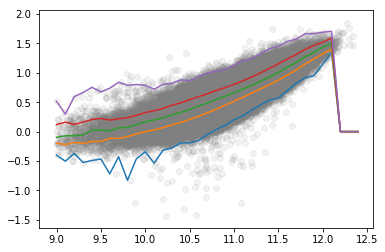

In [119]:
plt.plot(bins,percE)
plt.scatter(dfE.MsMendSerExp.values, dfE.logReSerExp.values, alpha=0.1, lw=1, color='grey')
plt.savefig('./Re-MstarETG_percentiles.eps')

In [ ]:
discard_ETGs = df

### quick check on which galaxies we are losing from the Yang+ catalog

In [101]:
df_check = pd.read_csv('missed_matches.txt',names=[ 'YgalId','ra','dec','z','AbsModel','zSource','Lcentsat','Mcentsat' ],
                      skiprows=1, delim_whitespace=True)

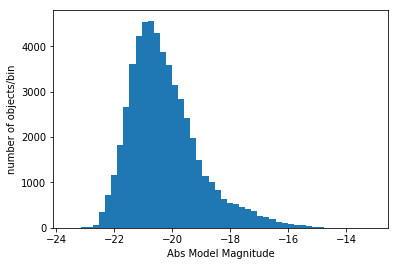

In [106]:
M = df_check.AbsModel
plt.hist(M, bins=50)
plt.ylabel('number of objects/bin')
plt.xlabel('Abs Model Magnitude')
plt.savefig('missed_galaxies_mag_distr.png')

In [98]:
df_merged_new.ra

Index(['AbsMag', 'AbsMagCent', 'BT', 'LCentSat', 'MCentSat', 'MhaloL',
       'MhaloM', 'Mmod', 'Mpet', 'MsMendCmodel',
       ...
       'ra_x_y', 'ra_y_y', 'veldisp_y', 'veldisperr_y', 'zMeert_y', 'zSDSS7_y',
       'zType_y', 'z_x_y', 'z_y_y', 'Vmaxwt'],
      dtype='object', length=110)

In [93]:
df = pd.read_csv('./Catalog_SDSS_complete.dat',delim_whitespace=True)
n_disk = fits_to_pandas('UPenn_PhotDec_Models_rband_Lorenzo.fits', extension=1)
n_disk['galcount'] = n_disk.index +1
ndisk = n_disk[['N_DISK','galcount']]
df_merged_new = df.merge(ndisk, on='galcount')


In [105]:
df_ = df_merged_new[['galcount','zMeert','Vmaxwt','NewLCentSat','MsMendSerExp',
                               'MsCent','AbsMag','logReSerExp', 'logReSerExpNotTrunc',
                               'logReSerExpCircNotTrunc','logR80NotTrunc','BT','n_bulge','ba_tot','TType','P_S0',
                               'P_bar_GZ2','P_bar_Nair10' ,'finalflag','raSDSS7','decSDSS7','LumDistance_y']]

In [102]:
catSer = fits_to_pandas('UPenn_PhotDec_Models_rband.fits', extension=3)
catSer['galcount'] = catSer.index +1
catSer = catSer[['galcount','BT','r_tot','n_bulge','ba_tot']]
catSer = catSer.rename(columns={'n_bulge': 'n_bulge_Ser','BT':'BT_Ser', 'r_tot':'r_tot_Ser',
                               'ba_tot':'ba_tot_Ser'})


/home/lorenzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/lorenzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10
/home/lorenzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


In [106]:

df = df_.merge(catSer,on='galcount')
df['logReSer'] = get_half_light_radius(df.LumDistance_y.values,df.zMeert.values,df.r_tot_Ser.values)
df['logReSer'] = df['logReSer']/np.sqrt(catSer['ba_tot_Ser'])

/home/lorenzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/lorenzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10
/home/lorenzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


In [ ]:
df_merged_new.LumDistance_y

In [103]:
df =df.query('MsMendSerExp>11. & MsMendSerExp<11.5 & TType>0   & NewLCentSat==1')
dfS0 = df.query('MsMendSerExp>11. & MsMendSerExp<11.5 & TType<0 &  P_S0>0.5')# & logReSerExp<1.6')
#df = pd.merge(df,dfS0, suffixes=('','old'))

In [77]:
df_merged.LumDistance

69292

57.46021597910175
3.8195026343590213


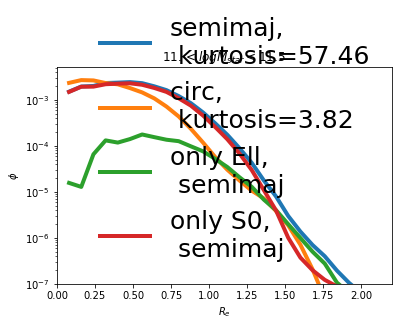

In [94]:
from scipy.stats import kurtosis,normaltest

bins=np.arange(0,2.5,0.08)
df = df[df.Vmaxwt>0]
htot = np.histogram(df.logReSerExp, bins,weights=df.Vmaxwt)[0]
hcirc = np.histogram(df.logReSerExpCircNotTrunc, bins, weights=df.Vmaxwt)[0]
dfE = df.query('P_S0<0.5')
dfS = df.query('P_S0>0.5')
hE = np.histogram(dfE.logReSerExp, bins, weights=dfE.Vmaxwt)[0]
hS = np.histogram(dfS.logReSerExp, bins, weights=dfS.Vmaxwt)[0]

print(kurtosis(df.logReSerExp))
print(kurtosis(df.logReSerExpCircNotTrunc))
fracper=len(df)/670722


skycov=8000.
fracsky=(skycov*fracper)/(4*np.pi*(180./np.pi)**2.)
plt.plot(bins[1:],htot/fracsky, label='semimaj,\n kurtosis='+str(np.round(kurtosis(df.logReSerExp),2)),lw=4)
plt.plot(bins[1:],hcirc/fracsky, label='circ, \n kurtosis='+str(np.round(kurtosis(df.logReSerExpCircNotTrunc),2)),lw=4)
#plt.plot(bins[1:],hcirc/fracsky, label='from Meert et al, \n de-circularized -0.05 dex' )
plt.plot(bins[1:],hE/fracsky, label='only Ell, \n semimaj' ,lw=4)
plt.plot(bins[1:],hS/fracsky, label='only S0, \n semimaj' ,lw=4)

from scipy.stats import norm

pdf = norm.pdf(bins, loc=1, scale=0.17)
#plt.plot(bins, pdf*np.max(hcirc/fracsky)/np.max(pdf), ls  =':')
plt.ylabel('$\phi$')
plt.xlabel('$R_{e}$')
plt.yscale('log')
plt.ylim(1.e-7)
plt.xlim(0.,2.2)
plt.legend(frameon=False, fontsize=25)
plt.title('$11.<logM_{star}<11.5$')
#plt.savefig('highmass_Re_tails_all_11.5.png')

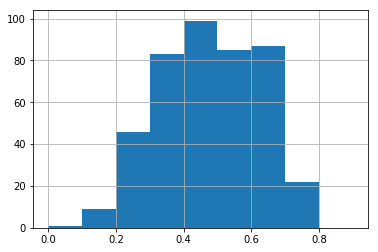

In [213]:
df.query('P_S0 < 0.5 & logReSerExp>1.3').BT.hist(bins=np.arange(0,1,0.1))

In [201]:
import seaborn as sns

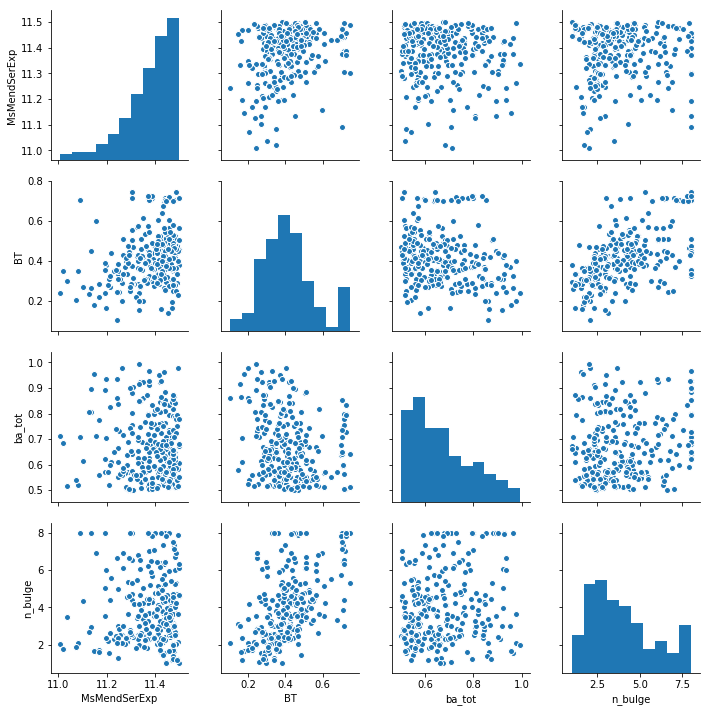

In [215]:
dd = df.query('P_S0 < 0.5 & logReSerExp>1.3 & finalflag==3')
sns.pairplot(data=dd[['MsMendSerExp','BT','ba_tot','n_bulge']] )

In [95]:
import matplotlib as mpl
 
mpl.rcParams['font.size']=22
mpl.rcParams['figure.figsize']=(12,10)
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['font.size']=45
mpl.rcParams['figure.figsize']=(16,16)
#mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['axes.linewidth']= 3.
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.linewidth']=5
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5 
mpl.rcParams['axes.titlepad'] = 20 

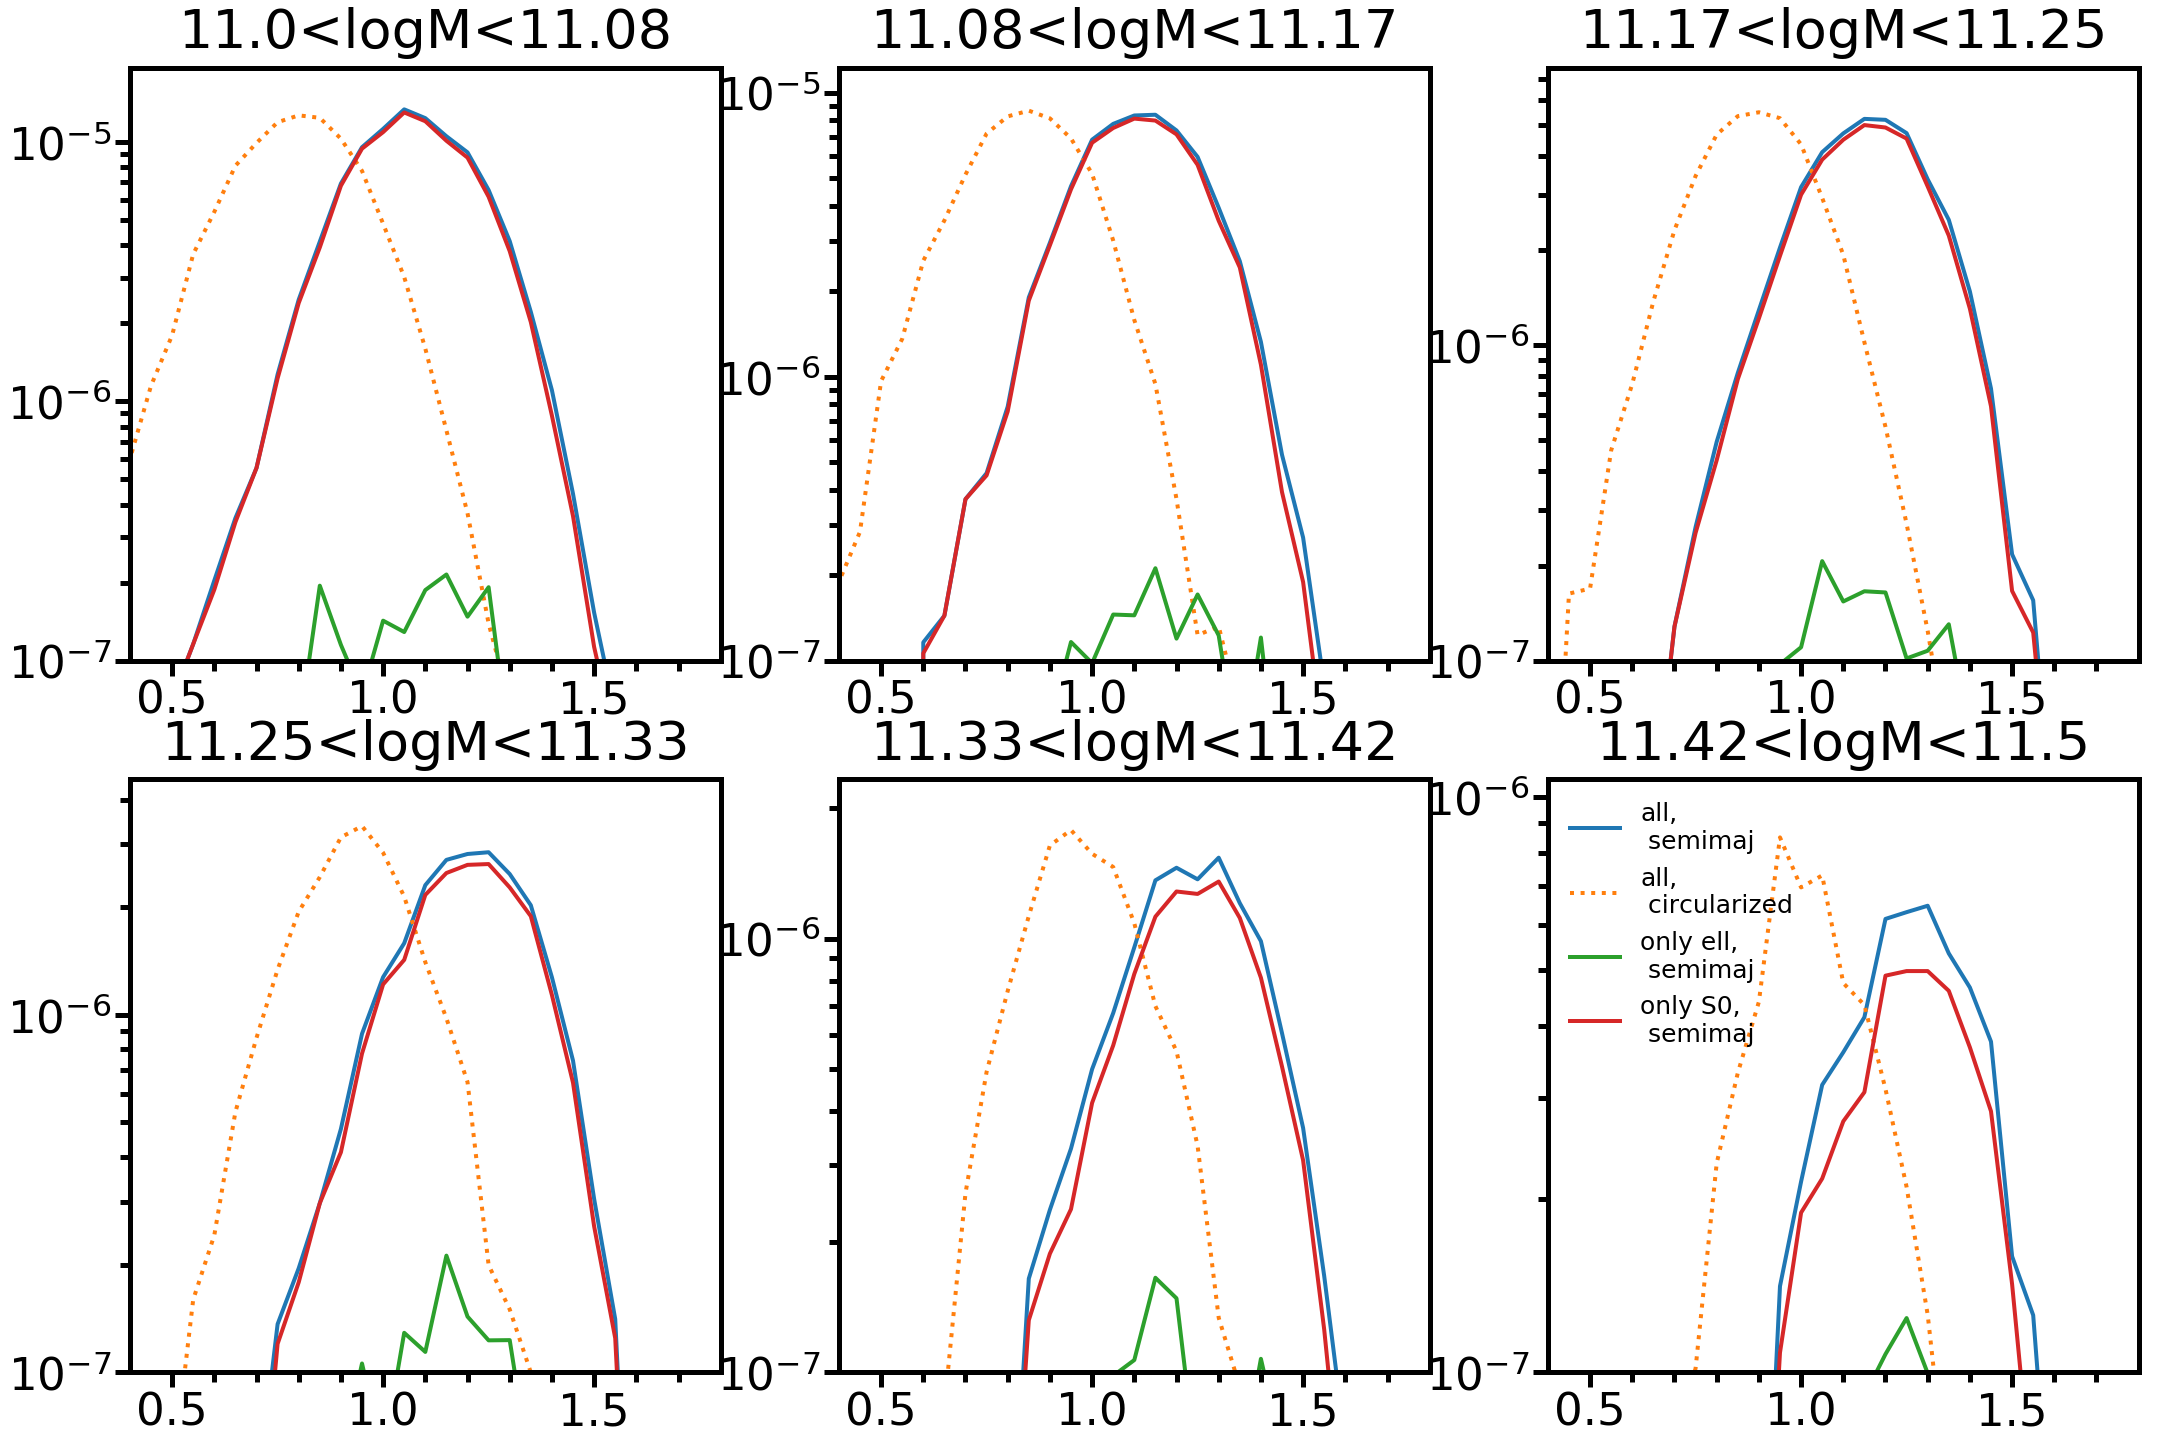

In [84]:
fig, ax = plt.subplots(2,3, figsize=(36,24))
m = np.linspace(11.,11.5,7)

df_ = df_merged_new.query('TType>0 & NewLCentSat==1 & P_S0<0.5')#  & ba_tot>0.5 & n_bulge>1')
df_ = df_[df_.Vmaxwt>0]
fracper=len(df_)/670722
skycov=8000.
fracsky=(skycov*fracper)/(4*np.pi*(180./np.pi)**2.)

for i,this_ax  in enumerate(ax.ravel()):
    df =df_.query('MsMendSerExp>'+str(m[i])+' & MsMendSerExp<'+str(m[i+1]))
    bins=np.arange(0,2.5,0.05)
    
    htrunc = np.histogram(df.logReSerExpNotTrunc, bins,weights=df.Vmaxwt)[0]
    hcirc = np.histogram(df.logReSerExpCircNotTrunc, bins,weights=df.Vmaxwt)[0]
  #  hnottrunc = np.histogram(df.logReSerExpNotTrunc-0.05, bins, weights=df.Vmaxwt)[0]
    hE = np.histogram(df.query('P_S0<0.5 & ba_tot>0.5').logReSerExpNotTrunc, bins, weights=df.query('P_S0<0.5 & ba_tot>0.5').Vmaxwt)[0]
    hS = np.histogram(df.query('P_S0>0.5').logReSerExpNotTrunc, bins, weights=df.query('P_S0>0.5').Vmaxwt)[0]

    this_ax.plot(bins[1:],htrunc/fracsky, label='all,\n semimaj',lw=4)
   # this_ax.plot(bins[1:],hnottrunc/fracsky, label='not truncated',lw=4 )
    this_ax.plot(bins[1:],hcirc/fracsky, label='all,\n circularized',lw=4, ls=':')
    this_ax.plot(bins[1:],hE/fracsky, label='only ell, \n semimaj' ,lw=4)    
    this_ax.plot(bins[1:],hS/fracsky, label='only S0, \n semimaj' ,lw=4)    
    this_ax.set_yscale('log')
    this_ax.set_ylim(1.e-7)
    this_ax.set_xlim(0.4,1.8)
    this_ax.set_title(str(np.round(m[i],2))+'<logM<'+str(np.round(m[i+1],2)))
ax[1][2].legend(fontsize=25, frameon=False)
#plt.savefig('sizefuncts_11.-11.5_nottrunc.png')
                            

In [66]:
df_merged_new.columns

Index(['galcount', 'zMeert', 'Vmaxwt', 'NewLCentSat', 'MsMendSerExp', 'MsCent',
       'AbsMag', 'logReSerExp', 'logReSerExpNotTrunc',
       'logReSerExpCircNotTrunc', 'logR80NotTrunc', 'BT', 'n_bulge', 'ba_tot',
       'TType', 'P_S0', 'P_bar_GZ2', 'P_bar_Nair10', 'finalflag', 'N_DISK'],
      dtype='object')

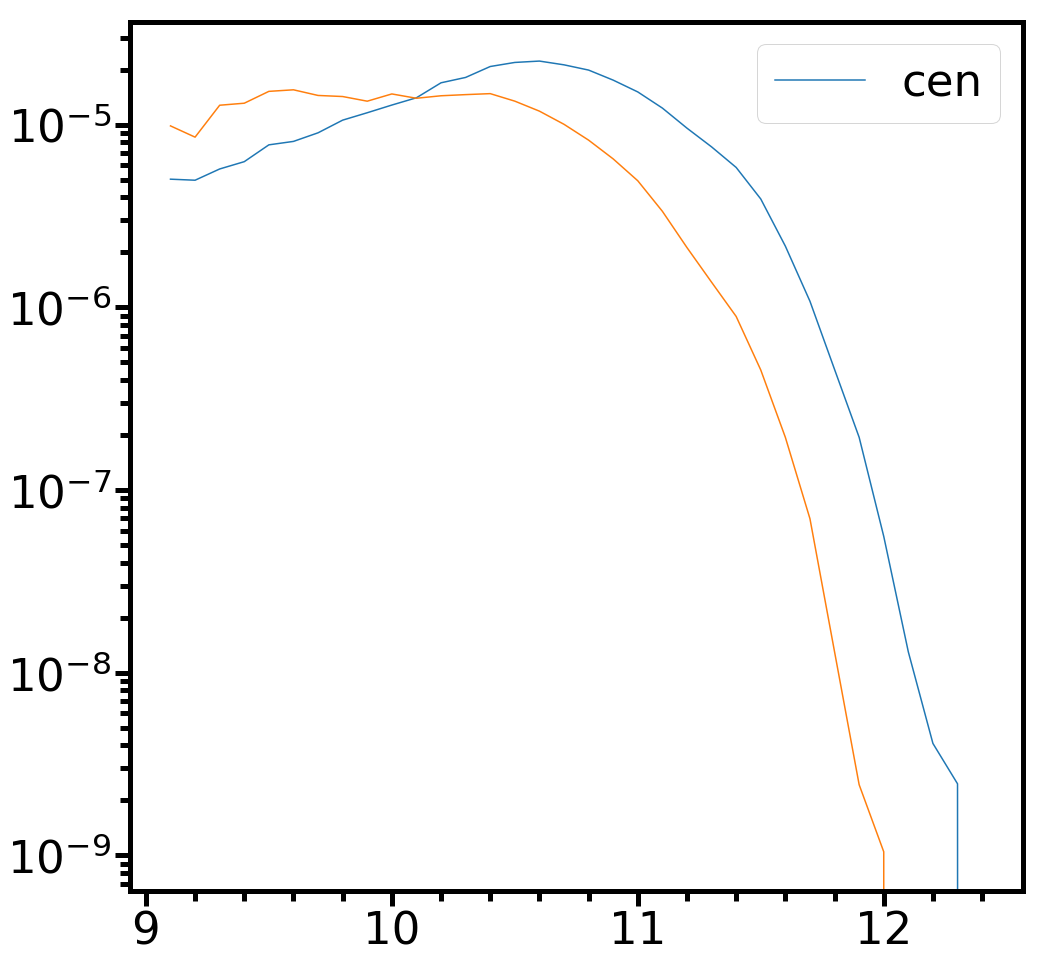

In [69]:
bins = np.arange(9,12.5,0.1)
dfcen = df_merged_new.query('NewLCentSat==1 & TType<0')
dfsat = df_merged_new.query('NewLCentSat==0 & TType<0')

h1 = np.histogram(dfcen.MsMendSerExp, bins=bins, weights=dfcen.Vmaxwt)[0]
h2 = np.histogram(dfsat.MsMendSerExp, bins=bins, weights=dfsat.Vmaxwt)[0]

plt.plot(bins[1:],h1, label='cen')
plt.plot(bins[1:], h2)
plt.yscale('log')
plt.legend()

In [269]:
df = df_merged_new.query('TType<0  & n_bulge>1 & MsMendSerExp>12')
len(df)

30

In [141]:
df_prova = pd.read_csv('ids_prova.txt', names=['r','rtrunc'],delim_whitespace=True)

In [147]:
df_prova['galcount'] = df_prova.index+1
dd = df_prova.merge(df_merged_new, on='galcount')

In [150]:
plt.scatter(dd.m_tot, dd.r-dd.r_tot_original)

AttributeError: 'DataFrame' object has no attribute 'm_tot'

In [169]:
10**1.

39.810717055349734

In [122]:
np.savetxt('ids.txt',df.galcount[:10].values)

(0, 1.9935566738864816)

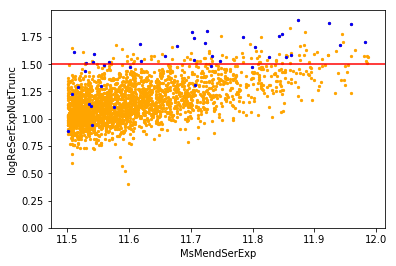

In [186]:
fig,ax =plt.subplots(1,1)
df.plot.scatter('MsMendSerExp','logReSerExpNotTrunc', s=5, color='orange',ax=ax)
df.query('ba_tot<0.4').plot.scatter('MsMendSerExp','logReSerExpNotTrunc', s=5,ax=ax, color='blue')

plt.axhline(1.5, color='red')
plt.ylim(0)

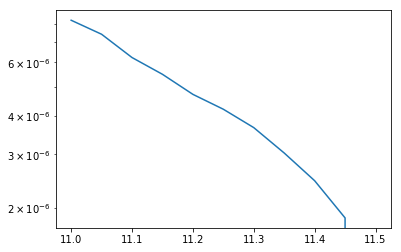

In [131]:
h = np.histogram(df.MsMendSerExp, bins=np.arange(11,11.6,0.05), weights=df.Vmaxwt)[0]
plt.plot(np.arange(11,11.6,0.05)[1:]-0.05, h)
plt.yscale('log')

In [107]:
from bokeh.io import curdoc
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, PreText, Select
from functools import lru_cache
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, gridplot

output_notebook()

Loading BokehJS ...

In [19]:
from bokeh.models import ColumnDataSource

x = list(range(-20, 21))
y0, y1 = [abs(xx) for xx in x], [xx**2 for xx in x]

# create a column data source for the plots to share
source = ColumnDataSource(data=dict(x=x, y0=y0, y1=y1))

TOOLS = "box_select,lasso_select,help"

# create a new plot and add a renderer
left = figure(tools=TOOLS, width=300, height=300)
left.circle('x', 'y0', source=source)

# create another new plot and add a renderer
right = figure(tools=TOOLS, width=300, height=300)
right.circle('x', 'y1', source=source)

p = gridplot([[left, right]])

show(p)

In [35]:
#@lru_cache()
#def get_data(a,b,c,d):
#df = pd.read_csv('./Catalog_SDSS_complete.dat',delim_whitespace=True)
df1 = df.query('MsMendSerExp>11 & MsMendSerExp<11.5 & TType<0 & NewLCentSat==1')
#    return df[[a,b,c,d]]
    
source = ColumnDataSource(data=df1[['MsMendSerExp','logReSerExp','logReSerExpCircNotTrunc','ba_tot']].to_dict())
            
source_static = ColumnDataSource(data=data=df1[['MsMendSerExp','logReSerExp','logReSerExpCircNotTrunc','ba_tot']].to_dict())

tools = 'pan,wheel_zoom,xbox_select,reset'

corr = figure(plot_width=350, plot_height=350,
              tools=tools)
corr.circle('MsMendSerExp', 'logReSerExp', size=2, source=source,
            selection_color="orange", alpha=0.6, nonselection_alpha=0.1, selection_alpha=0.4)

ts1 = figure(plot_width=900, plot_height=200, tools=tools, active_drag="xbox_select")
ts1.circle('logReSerExp', 'ba_tot', source=source_static)
ts1.circle('logReSerExp', 'ba_tot', size=1, source=source, color=None, selection_color="orange")

ts2 = figure(plot_width=900, plot_height=200, tools=tools, x_axis_type='datetime', active_drag="xbox_select")
ts2.circle('logReSerExpCircNotTrunc', 'ba_tot', source=source_static)
ts2.circle('logReSerExpCircNotTrunc', 'ba_tot', size=1, source=source, color=None, selection_color="orange")


def selection_change(attrname, old, new):
    #t1, t2 = ticker1.value, ticker2.value
    data = get_data('MsMendSerExp','logReSerExp','logReSerExpCircNotTrunc','ba_tot')
    selected = source.selected.indices
    if selected:
        data = data.iloc[selected, :]

source.selected.on_change('indices', selection_change)

update()
curdoc().add_root(row(corr,ts1,ts2))

In [108]:
from bokeh.plotting import figure, show
from bokeh.io import output_file
from bokeh.models import ColumnDataSource, Label, CategoricalColorMapper, NumeralTickFormatter, Range1d
from bokeh.layouts import gridplot

In [92]:
from bokeh.util.compiler import TypeScript

TS_CODE = """
import * as p from "core/properties"
import {Label, LabelView} from "models/annotations/label"
declare const katex: any

export class LatexLabelView extends LabelView {
  model: LatexLabel

  render(): void {
    //--- Start of copied section from ``Label.render`` implementation

    // Here because AngleSpec does units tranform and label doesn't support specs
    let angle: number
    switch (this.model.angle_units) {
      case "rad": {
        angle = -this.model.angle
        break
      }
      case "deg": {
        angle = (-this.model.angle * Math.PI) / 180.0
        break
      }
      default:
        throw new Error("unreachable code")
    }

    const panel = this.panel != null ? this.panel : this.plot_view.frame

    const xscale = this.plot_view.frame.xscales[this.model.x_range_name]
    const yscale = this.plot_view.frame.yscales[this.model.y_range_name]

    let sx = this.model.x_units == "data" ? xscale.compute(this.model.x) : panel.xview.compute(this.model.x)
    let sy = this.model.y_units == "data" ? yscale.compute(this.model.y) : panel.yview.compute(this.model.y)

    sx += this.model.x_offset
    sy -= this.model.y_offset

    //--- End of copied section from ``Label.render`` implementation
    // Must render as superpositioned div (not on canvas) so that KaTex
    // css can properly style the text
    this._css_text(this.plot_view.canvas_view.ctx, "", sx, sy, angle)

    // ``katex`` is loaded into the global window at runtime
    // katex.renderToString returns a html ``span`` element
    katex.render(this.model.text, this.el, {displayMode: true})
  }
}

export namespace LatexLabel {
  export type Attrs = p.AttrsOf<Props>

  export type Props = Label.Props
}

export interface LatexLabel extends LatexLabel.Attrs {}

export class LatexLabel extends Label {
  properties: LatexLabel.Props

  constructor(attrs?: Partial<LatexLabel.Attrs>) {
    super(attrs)
  }

  static initClass() {
    this.prototype.default_view = LatexLabelView
  }
}
LatexLabel.initClass()
"""


class LatexLabel(Label):
    """A subclass of the Bokeh built-in `Label` that supports rendering
    LaTex using the KaTex typesetting library.

    Only the render method of LabelView is overloaded to perform the
    text -> latex (via katex) conversion. Note: ``render_mode="canvas``
    isn't supported and certain DOM manipulation happens in the Label
    superclass implementation that requires explicitly setting
    `render_mode='css'`).
    """
    __javascript__ = ["https://cdnjs.cloudflare.com/ajax/libs/KaTeX/0.6.0/katex.min.js"]
    __css__ = ["https://cdnjs.cloudflare.com/ajax/libs/KaTeX/0.6.0/katex.min.css"]
    __implementation__ = TypeScript(TS_CODE)

In [163]:
#df1 = pd.read_csv('./Catalog_SDSS_complete.dat',delim_whitespace=True)
#dfphot = pd.read_csv('chi2nu_SerExp.dat', sep= ' ')
#df1 = df1.merge(dfphot, on='galcount')
df1 = df.query('MsMendSerExp>11. & MsMendSerExp<11.5 & TType<0 & P_S0<0.5 & \
              NewLCentSat==1  & logReSerExpCircNotTrunc>-0.5 & (finalflag==1 | finalflag==5) & n_bulge_Ser>0')
#    return df[[a,b,c,d]]
    
source = ColumnDataSource(data=df1[['MsMendSerExp','logReSerExp','logReSerExpCircNotTrunc',
                                    'logReSer',
                                    'ba_tot','n_bulge','n_bulge_Ser',
                                    'BT','BT_Ser']].to_dict(orient='list'))


tools = 'pan,wheel_zoom,lasso_select,reset'

corr = figure(plot_width=350, plot_height=350,
              tools=tools)
corr.circle('MsMendSerExp', 'logReSerExp', size=1, source=source,
            selection_color="orange", alpha=0.6,  selection_alpha=0.4)
corr0 = figure(plot_width=350, plot_height=350,
              tools=tools)
corr0.circle('MsMendSerExp', 'logReSer', size=1, source=source,
            selection_color="orange", alpha=0.6,  selection_alpha=0.4)
corr1 = figure(plot_width=350, plot_height=350,
              tools=tools, active_drag="lasso_select")
corr1.circle('MsMendSerExp', 'logReSerExpCircNotTrunc', size=1, source=source,
            selection_color="orange", alpha=0.6, selection_alpha=0.4)
ts1 = figure(plot_width=350, plot_height=350, tools=tools, active_drag="lasso_select")
#ts1.circle('logReSerExp', 'ba_tot', source=source)
ts1.circle('MsMendSerExp', 'n_bulge', size=5, source=source, color=None,
           alpha=0.6,  selection_alpha=0.4,selection_color="orange")

ts2 = figure(plot_width=350, plot_height=350, tools=tools,  active_drag="lasso_select")
#ts2.circle('logReSerExpCircNotTrunc', 'ba_tot', source=source)
ts2.circle('MsMendSerExp', 'n_bulge_Ser', size=5, source=source, color=None,
           alpha=0.6,  selection_alpha=0.4,selection_color="orange")


ts3 = figure(plot_width=350, plot_height=350, tools=tools,  active_drag="lasso_select")
#ts2.circle('logReSerExpCircNotTrunc', 'ba_tot', source=source)
ts3.circle('MsMendSerExp', 'BT', size=5, source=source, color=None, 
           alpha=0.6,  selection_alpha=0.4,selection_color="orange")


ts4 = figure(plot_width=350, plot_height=350, tools=tools,  active_drag="lasso_select")
#ts2.circle('logReSerExpCircNotTrunc', 'ba_tot', source=source)
ts4.circle('MsMendSerExp', 'BT_Ser', size=5, source=source, color=None,
           alpha=0.6,  selection_alpha=0.4,selection_color="orange")


corr.xaxis.axis_label = r'$logM_{star}$'
corr1.xaxis.axis_label = r'$logM_{star}$'
corr.yaxis.axis_label = r'$log R_{e,maj,trunc}$'
corr1.yaxis.axis_label = r'$log R_{e,circ,nottrunc}$'
corr0.yaxis.axis_label = r'$log R_{e,maj,Ser}$'
corr0.xaxis.axis_label = r'$logM_{star}$'

ts1.xaxis.axis_label = r'$logM_{star}$'
ts1.yaxis.axis_label = 'n_bulge'
ts2.xaxis.axis_label = r'$logM_{star}$'
ts2.yaxis.axis_label = 'n_bulge_Ser'

ts3.xaxis.axis_label = r'$logM_{star}$'
ts3.yaxis.axis_label = 'B/T'
ts4.xaxis.axis_label = r'$logM_{star}$'
ts4.yaxis.axis_label = 'B/T Ser'


corr.x_range = Range1d(10.9,11.6)
corr1.x_range = Range1d(10.9,11.6)
corr.y_range = Range1d(0,2)
corr1.y_range = Range1d(0,2)
ts4.y_range = Range1d(0.5,1.5)
#ts1.x_range = Range1d(0,2)
#ts2.x_range = Range1d(0,2)
p = gridplot([corr,corr1,ts1,ts2,ts3,ts4], ncols=2)

show(p)

In [159]:
df1 = df.query('MsMendSerExp>11.1 & MsMendSerExp<11.2 & TType<0 & P_S0<0.5 & \
              NewLCentSat==1  & finalflag==3 & n_bulge_Ser>0.')
#df1.BT.hist(bins=np.arange(0.,1.,0.1))



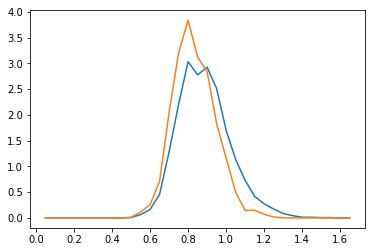

In [162]:
bins= np.arange(0,1.7,0.05)
h = np.histogram(df1.logReSerExp, bins, weights=df1.Vmaxwt, density=True)[0]
h1 = np.histogram(df1.query('BT>0.6').logReSerExp, bins, weights=df1.query('BT>0.6').Vmaxwt, density=True)[0]

plt.plot(bins[1:], h)
plt.plot(bins[1:], h1)

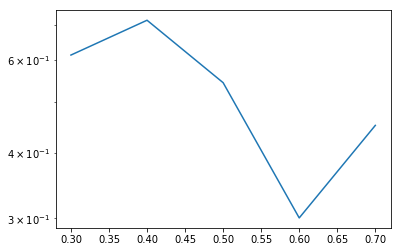

In [160]:
from scipy.stats import kurtosis
BTbins = [0.3,0.4,0.5,0.6,0.7]

x = []
y = []
for bt in BTbins:
    R = df1[df1.BT>bt].logReSerExp
    k1 = kurtosis(R)
    x.append(bt)
    y.append(k1)
plt.plot(x,y)
plt.yscale('log')

In [149]:
df1.query('BT<0.4')[['raSDSS7','decSDSS7']].to_csv('radec_BT_le_0.4.txt', index=False)

In [147]:
df1.query('BT<0.4')[['raSDSS7','decSDSS7']]

,raSDSS7,decSDSS7
421,191.192567,-1.019302
1383,215.174896,-0.676866
1408,217.468915,-0.694312
2161,218.018020,-0.316183
2169,218.770059,-0.404444
2526,183.422284,0.196511
3479,200.074646,0.540148
5434,199.805186,-1.032868
6140,173.806817,-0.538440
6309,185.239466,-0.445303


In [175]:
Ellip = (df.TType<=0) & (df.P_S0<0.5) & (df.BT>0.6) & (df.ba_tot>0.5)
S0s = (df.TType<=0) & (df.P_S0>0.5)
ETGs = df.TType<=0

In [173]:
len(df[ETGs])

241958

In [176]:
len(df[Ellip | S0s])/len(df[ETGs])

0.9430107704642955